In [1]:
import tensorflow as tf
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random
import numpy as np

Epoch [100/300], Train Loss: 0.36366915702819824, Test Loss: 1.2809245586395264
Epoch [200/300], Train Loss: 0.24249623715877533, Test Loss: 2.930375814437866
Epoch [300/300], Train Loss: 0.24258293211460114, Test Loss: 2.927748918533325


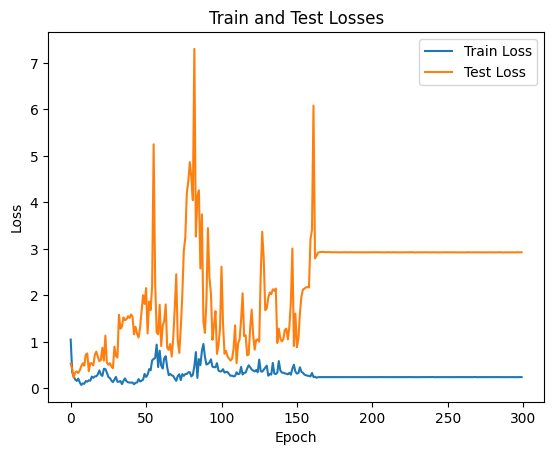

Accuracy on test set: 0.8722222447395325


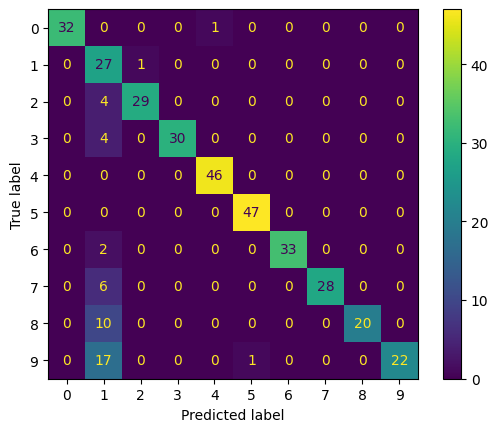

In [12]:
CREATE_CLASS=True # Create class from scratch; otherwise use nn.Sequential to create the class
SGD=False # SGD or Adam
IRIS=False # iris or mnist
SHOW=False # returns picture of digit for mnist

# Load Iris dataset
if IRIS:
    examples = load_iris()
else:
    examples = load_digits() # https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html; 10 digits;  1797 examples
    if SHOW:
        idx=random.randint(0,len(examples.target))
        print(examples.data[idx])
        print(examples.data[idx].reshape(8,8))
        print(examples.target[idx])
        plt.matshow(examples.data[idx].reshape(8,8), cmap=plt.cm.gray_r)
        plt.show()

X = examples.data
y = examples.target

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.int32)

# Instantiate the model
input_size = X_train_tensor.shape[1]
hidden_size = 16
output_size = len(examples.target_names)
batch_size=120
num_epochs = 300
# Optimizer specific options
learning_rate=0.1
regularization_param=0.001
momentum_param=0.9
# Dropout: if p>0
dropout_p=0.1 # During training, randomly zeroes some of the elements of the input tensor with probability p.'''


# Create datasets (instead of DataLoader) which makes it easier to use mini batches

train_ds = tf.data.Dataset.from_tensor_slices((X_train_tensor, y_train_tensor)).shuffle(len(X_train)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test_tensor, y_test_tensor)).batch(batch_size)


########################################################### NN model
if CREATE_CLASS:
    # Create model, first defining the class with a forward method
    class ThreeLayerNet(tf.keras.Model):
        def __init__(self, input_size, hidden_size, output_size):
            super(ThreeLayerNet, self).__init__()
            self.fc1 = tf.keras.layers.Dense(hidden_size, activation='relu')
            self.fc2 = tf.keras.layers.Dense(hidden_size, activation='relu')
            self.fc3 = tf.keras.layers.Dense(output_size)
            self.dropout = tf.keras.layers.Dropout(rate=dropout_p)  # Dropout layer with dropout probability
        def call(self, x):
            x = self.dropout(tf.nn.relu(self.fc1(x)))
            x = self.dropout(tf.nn.relu(self.fc2(x)))
            x = self.fc3(x)
            return x

    model = ThreeLayerNet(input_size, hidden_size, output_size)
else:
    # Or, in alternative, use Sequential
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(hidden_size, activation='relu'),
        tf.keras.layers.Dropout(dropout_p),
        tf.keras.layers.Dense(hidden_size, activation='relu'),
        tf.keras.layers.Dropout(dropout_p),
        tf.keras.layers.Dense(output_size)
    ])

####################################################################################################
# Define loss function and optimizer
# Either torch.nn.NLLLoss or torch.nn.CrossEntropyLoss can be used: CrossEntropyLoss (https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) implements softmax internally
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) #
# Optimizer: optimizer object that will hold the current state and will update the parameters based on the computed gradients
# for param in model.parameters(): print(param.data)
if SGD:
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum_param)
else:
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

# Lists to store train and test losses
train_losses = []
test_losses = []

# Training the model
for epoch in range(num_epochs):
    train_loss = tf.keras.metrics.Mean()  # Initialize train loss metric

    for x_batch, y_batch in train_ds:
        # Forward pass
        with tf.GradientTape() as tape:
            pred = model(x_batch)
            loss = criterion(y_batch, pred)

        # Backward pass and optimization
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss.update_state(loss)  # Update train loss metric with current batch loss

    train_losses.append(train_loss.result().numpy())  # Append mean train loss to list

    # Test the model
    test_loss = tf.keras.metrics.Mean()
    for x_test_batch, y_test_batch in test_ds:
        pred = model(x_test_batch, training=False)
        loss = criterion(y_test_batch, pred)
        test_loss.update_state(loss)
    test_losses.append(test_loss.result().numpy())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss.result()}, Test Loss: {test_loss.result()}')



# Plotting train and test losses
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Losses')
plt.legend()
plt.show()

# Testing the model
test_accuracy = tf.keras.metrics.Accuracy()
for x_test_batch, y_test_batch in test_ds:
    pred = model(x_test_batch, training=False)
    test_accuracy.update_state(y_test_batch, tf.argmax(pred, axis=1))

print(f'Accuracy on test set: {test_accuracy.result().numpy()}')

# Confusion matrix
predictions = []
true_labels = []
for x_test_batch, y_test_batch in test_ds:
    pred = model(x_test_batch, training=False)
    predictions.extend(tf.argmax(pred, axis=1).numpy())
    true_labels.extend(y_test_batch.numpy())

cm = confusion_matrix(true_labels, predictions)
labels = np.unique(true_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()